# Analyzing Spectral Reflectance within Intertidal Zones

**Summary**
This tutorial demonstrates how to use Earth observation data from NASA's ECOSTRESS and EMIT missions alongside in situ spectral reflectance measurements to investigate environmental conditions and biodiversity in the intertidal zones of Southern California. Specifically, this notebook focuses on analyzing the variability of shorelines by analyzing the coefficient of variation and testing the hypothesis within the interridal zones: Greater Coefficient of Variation = Greater Variability

We aim to better understand how spectral signatures correspond to observable biological patterns by integrating:

- ECOSTRESS LST and emissivity layers (including LST, cloud mask, and quality control flags)

- EMIT full-band Level 2A reflectance data, and

- Normalized field-collected spectral data

Ultimately, the goal is to support coastal monitoring and climate adaptation efforts by incorporating various NASA missions

**Learning Objectives**

- What is spectral diversity and how does it relate to biodiversity?
- Does a greater coefficient of variation = more variability within the intertidal zones?
- How to prepare and analyze reflectance data sets from on-ground and satellite observations. 
- Compare spectral diversity across sites and sensor types using summary statistics and visual plots.

**This Code Assumes You Have:**
- One normalized CSV for field reflectance - in situ data
- One .geojson polygon file for ROI - Created through coordinates or a polygon mapped in QGIS/ArcGIS
- ECOSTRESS and EMIT granules .txt file from VITALS Tutorial 1

**Relevant Links**
- Process data for analysis: https://github.com/kyla-mbc/Intertidal/blob/main/DataProcess.ipynb
- To process .sed data from instrument to csv: https://github.com/kyla-mbc/Intertidal/blob/main/PythonCode/SED.py
- To normalize raw spectra csv: https://github.com/kyla-mbc/Intertidal/blob/main/PythonCode/SED.py
- To manually download EMIT / ECOSTRESS Data: https://ecostress.jpl.nasa.gov/downloads/tutorials/06-Downloading_from_AppEEARS.pdf
- This Jupyter Notebook would not be possible without the help and structure of the VITALS tutorials to find and analyze concurrent ECOSTRESS and EMIT data: https://github.com/nasa/VITALS/tree/main


_______________________________________________________________________________________________________________________________________________________

## Part 1: Data Setup and Dependencies

Create a working environment with required packages. Be sure to active your environment and choose the right kernel each time you work on your project.

In [5]:
#Run in Terminal: mamba create -n (environmentname) -c conda-forge --yes python=3.12 gdal fiona hvplot geoviews rioxarray rasterio jupyter geopandas earthaccess jupyter_bookeh h5py h5netcdf spectral sckit-image jupyterlab seaborn dask ray-default pystac-client odc-stac pyresample libgal-hdf4 harmony-py

# Setup & Imports
import warnings
warnings.filterwarnings("ignore")

# Import required libraries
import os
import json
import folium
import earthaccess
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthaccess
import requests

from branca.element import Figure
from shapely.geometry import MultiPolygon, Polygon, box
from shapely.geometry.polygon import orient
from datetime import timedelta
from earthaccess import DataGranules
from pathlib import Path
from tqdm.notebook import tqdm

### Part 1a: NASA Earthdata Authentication

To access data from NASA Earthdata, you must first authenticate using the earthaccess library. Follow the interactive login prompt that appears to sign in with your NASA Earthdata credentials (email and password associated with your Earthdata account). This step ensures you have authorized access to download and search Earth observation datasets.

If you haven’t registered yet, create a free account here: https://urs.earthdata.nasa.gov/users/new

In [6]:
# Authenticate with NASA Earthdata
auth = earthaccess.Auth()
auth.login(strategy="interactive", persist=True)
print('Authenticated:', auth.authenticated)

Authenticated: True


### Part 1b: Define Paths 
In order to put all the data together (ECOSTRESS, EMIT, in situ), it is helpful to know where they are all located and assigning them to variables will help especially with longer file names. To download data for concurrent ECOSTRESS and EMIT data, refer to Intertidal.ipynb jupyter notebook.

You may not use all the paths or all of them at once, but it is good to have them organized. 

In [ ]:
# Define Paths
#Base Path
base_dir = Path("/Users/kylamonique/Desktop/JPLFiles/PythonCode") # Common folder for all inputs and outputs. 

#In Situ Information
#Normalized csv files
LCDMground_truth_csv = Path("/Users/kylamonique/Desktop/JPLFiles/NormalizedOutputs/LCDMNormalized.csv") #Normalized in situ csv for analysis.
SDground_truth_csv = Path("/Users/kylamonique/Desktop/JPLFiles/NormalizedOutputs/SDNormalized.csv")
PVground_truth_csv = Path("/Users/kylamonique/Desktop/JPLFiles/NormalizedOutputs/PVNormalized.csv")

#ROI Polygons 
LCDMPolygon = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMPolygon.geojson")
SDPolygon = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/SDPolygon.geojson")
PVPolygon = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/PVPolygon.geojson")

#ROI Quadrats in situ
LCDMQuadrat = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMQuadrat.geojson") 
SDQuadrat = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/SDQuadrat.geojson")
PVQuadrat = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/PVQuadrat.geojson")

#if only using one site, use these variables / paths instead. 
# roi_path = Path("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMPolygon.geojson") #Region of Interest - Polygon
# roi_point=Path("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMQuadrat.geojson") #Region of Interest - Quadrat Points

#ecostress and emit data - LCDM 
ecostress_tif_pathLCDM  = Path("/Users/kylamonique/Desktop/JPLFiles/PythonCode/ECOSTRESS_Data/LCDM") #ECOSTRESS .tif folder (optional if not using earthdata)
emit_nc_pathLCDM = Path("/Users/kylamonique/Desktop/JPLFiles/PythonCode/ECOSTRESS_Data/LCDM/PythonCode/ECOSTRESS_Data/LCDM/LCDM_ECO_L2T_LSTE.002_70m_aid0001_11N.nc")  # <-- Update this if your filename is different

#ecostress and emit data - San Diego
ecostress_tif_pathSD = Path("/Users/kylamonique/Desktop/JPLFiles/PythonCode/ECOSTRESS_Data/LCDM") #ECOSTRESS .tif folder (optional if not using earthdata)
emit_nc_pathSD = Path("/Users/kylamonique/Desktop/JPLFiles/PythonCode/ECOSTRESS_Data/LCDM/PythonCode/ECOSTRESS_Data/LCDM/LCDM_ECO_L2T_LSTE.002_70m_aid0001_11N.nc")  # <-- Update this if your filename is different

#ecostress and emit data - Palos Verdes
ecostress_tif_pathPV = Path("/Users/kylamonique/Desktop/JPLFiles/PythonCode/ECOSTRESS_Data/LCDM") #ECOSTRESS .tif folder (optional if not using earthdata)
emit_nc_pathPV = Path("/Users/kylamonique/Desktop/JPLFiles/PythonCode/ECOSTRESS_Data/LCDM/PythonCode/ECOSTRESS_Data/LCDM/LCDM_ECO_L2T_LSTE.002_70m_aid0001_11N.nc")  # <-- Update this if your filename is different

ecostress_tif_path.mkdir(exist_ok=True) #make directory if it does not exist. 


## Part 2: Visualizing Regions of Interest
It is helpful to validate whether your data was loaded in properly. Visualizing your AOI will also assist in analysis. You can either view this as a plot or through an interactive map.

       filename   latitude   longitude  Dist_Coast  Transect#  Quadrat#  \
0  IMG_2404.JPG  33.589467 -117.868247           0          1         1   
1  IMG_2405.JPG  33.589403 -117.868331          10          1         2   
2  IMG_2406.JPG  33.589353 -117.868414          20          1         3   
3  IMG_2407.JPG  33.589294 -117.868492          30          1         4   
4  IMG_2408.JPG  33.589247 -117.868592          40          1         5   

                      geometry  
0  POINT (-117.86825 33.58947)  
1   POINT (-117.86833 33.5894)  
2  POINT (-117.86841 33.58935)  
3  POINT (-117.86849 33.58929)  
4  POINT (-117.86859 33.58925)  
       filename   latitude   longitude  Dist_coast  Transect#  Quadrat#  \
0  IMG_8100.JPG  32.725650 -117.257706           0          1         1   
1  IMG_8101.JPG  32.725681 -117.257814          10          1         2   
2  IMG_8102.JPG  32.725758 -117.257897          20          1         3   
3  IMG_8104.JPG  32.725711 -117.257606           0 

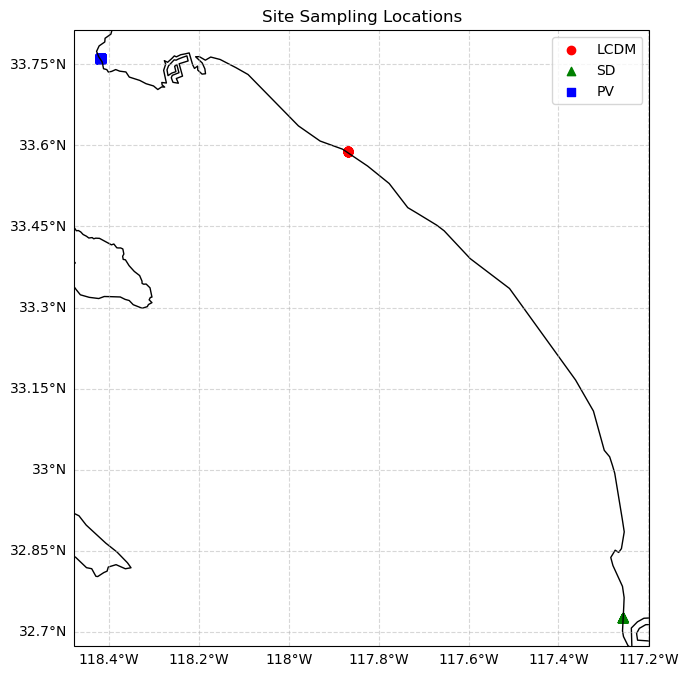

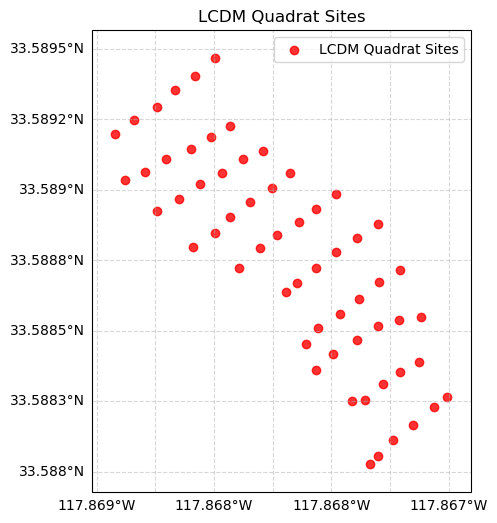

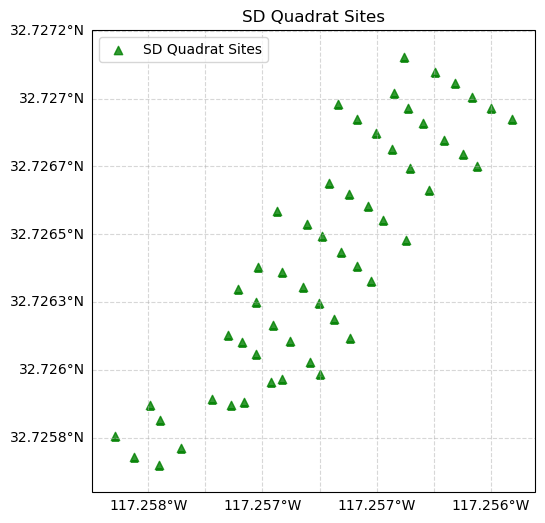

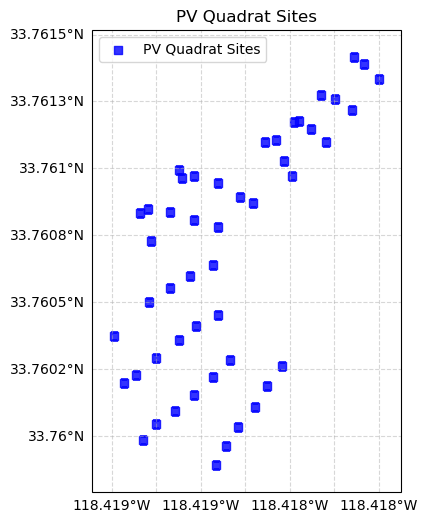

In [10]:
#Visualize Sample Locations on a Plot.
# Load GeoJSON files
print(LCDMQuadrat.head())
print(SDQuadrat.head())
print(PVQuadrat.head())

# Set up the plot with Cartopy for mapping
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add high-resolution coastlines and gridlines
ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = gl.right_labels = False

# Plot the GeoDataFrames
LCDMQuadrat.plot(ax=ax, marker='o', color='red', label='LCDM', transform=ccrs.PlateCarree())
SDQuadrat.plot(ax=ax, marker='^', color='green', label='SD', transform=ccrs.PlateCarree())
PVQuadrat.plot(ax=ax, marker='s', color='blue', label='PV', transform=ccrs.PlateCarree())

plt.legend()
plt.title("Site Sampling Locations")
plt.show()


# Visualize all locations within one grid.
def plot_quadrats(gdf, title, color, marker):
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ax.coastlines(resolution='10m')    # Plot coastlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)     # Gridlines
    gl.top_labels = gl.right_labels = False
    gdf.plot(ax=ax, color=color, marker=marker, alpha=0.8, transform=ccrs.PlateCarree(), label=title)     # Plot quadrats

    # Auto-zoom to the bounds of the GeoDataFrame (pad for clarity)
    minx, miny, maxx, maxy = gdf.total_bounds
    padding = 0.0001 # degree buffer
    ax.set_extent([minx - padding, maxx + padding, miny - padding, maxy + padding], crs=ccrs.PlateCarree())

    # Title and legend
    plt.title(title)
    plt.legend()
    plt.show()


# Visualize each location separately
#Coasts will not be visible due to space constraints.
plot_quadrats(LCDMQuadrat, "LCDM Quadrat Sites", "red", "o") 
plot_quadrats(SDQuadrat,   "SD Quadrat Sites",   "green", "^")
plot_quadrats(PVQuadrat,   "PV Quadrat Sites",   "blue", "s")


Alternatively, you could also plot your ROIs as well as the quadrats within them through an interactive map. 

On the top right corner of the map, you can toggle on and off the various layers of the map.

In [11]:
#Visualize Sample Locations on an Interactive Map.

# Load all 3 ROI polygon GeoJSONs
LCDMpolygon = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMPolygon.geojson")
SDpolygon   = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/SDPolygon.geojson")
PVpolygon   = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/PVPolygon.geojson")

#Load points within locations
LCDM_points = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMQuadrat.geojson")
SD_points   = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/SDQuadrat.geojson")
PV_points   = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/PVQuadrat.geojson")


# Combine to get a universal bounding box
combined = gpd.GeoDataFrame(pd.concat([LCDMpolygon, SDpolygon, PVpolygon], ignore_index=True), crs=LCDMpolygon.crs)
bbox = combined.total_bounds  # [minx, miny, maxx, maxy]
agu_bbox = gpd.GeoDataFrame(geometry=[combined.unary_union.envelope], crs=combined.crs)

# Create interactive map using folium and Google Satellite basemap
fig_roi = Figure(width="750px", height="375px")
map_roi = folium.Map(
    tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', 
    attr='Google Satellite', 
    name='Google Satellite'
)
fig_roi.add_child(map_roi)

# Add bounding box layer
folium.GeoJson(
    agu_bbox,
    name='Bounding Box'
).add_to(map_roi)

# Add all 3 polygons to the map with different colors
LCDMpolygon.explore(
    m=map_roi,
    name="LCDM",
    column=None,
    style_kwds=dict(color="red", fillOpacity=0.1, weight=10),
    popup=True
)

SDpolygon.explore(
    m=map_roi,
    name="SD",
    column=None,
    style_kwds=dict(color="green", fillOpacity=0.1, weight=10),
    popup=True
)

PVpolygon.explore(
    m=map_roi,
    name="PV",
    column=None,
    style_kwds=dict(color="blue", fillOpacity=0.1, weight=10),
    popup=True
)

# Add LCDM points
for _, row in LCDM_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="red",
        fill=True,
        fill_color="red",
        popup=row.get("name", "LCDM Point")
    ).add_to(map_roi)

# Add SD points
for _, row in SD_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="green",
        fill=True,
        fill_color="green",
        popup=row.get("name", "SD Point")
    ).add_to(map_roi)

# Add PV points
for _, row in PV_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="blue",
        fill=True,
        fill_color="blue",
        popup=row.get("name", "PV Point")
    ).add_to(map_roi)



# Add layer control toggle
map_roi.add_child(folium.LayerControl())

# Fit map bounds to the union of all 3 polygons
minx, miny, maxx, maxy = combined.total_bounds
map_roi.fit_bounds(bounds=((miny, minx), (maxy, maxx)))

# Show map
fig_roi


## Part 3: Load In Situ Data

Load in and preview the in situ data set. 


# To Be Continued...

### Part  Streaming EMIT Data

To begin, open the text file with your ECOSTRESS / EMIT granules and read the URLs into a list. The list that will be printed out is a subset of scenes from the previous granule searches.

In [ ]:
# List the files in the required granules.txt
file_list = '/Users/kylamonique/Desktop/JPLFiles/PythonCode/required_granules.txt'
with open(file_list) as f: 
    urls = [line.rstrip('\n') for line in f]
urls

Next we need to start an fsspec https session, and use it to open the urls. This will allow us to access the data in the cloud like its part of our local file system. We’ll use this method to access the EMIT netCDF files, but a slightly different workflow for the ECOSTRESS data, which we will show later.

In [ ]:
# Get Https Session using Earthdata Login Info
fs = earthaccess.get_fsspec_https_session()

# Define Local Filepath
emit_fp = fs.open(urls[1])
emit_qa_fp = fs.open(urls[2])

### Part  Utilizing ECOSTRESS and EMIT Data

In order to perform an analysis on spectral reflectance and variability, you need data! Replace the file paths below with the appropriate file paths for your ECOSTRESS and EMIT data. Ideally, you would want the data to be from the same dates or within a close date range.